**EN2550 2021: Object Counting on a Convey Belt**

---



180428T

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


%matplotlib inline

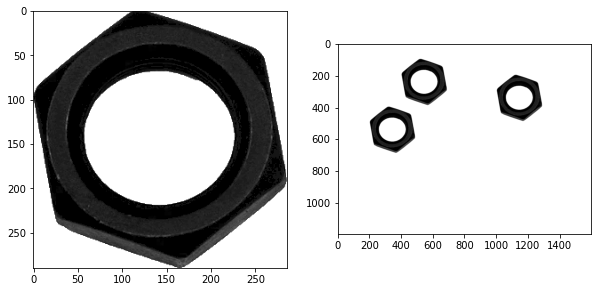

In [4]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

PART 1

In [5]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [6]:
kernel = np.ones((3,3),dtype='uint8')
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

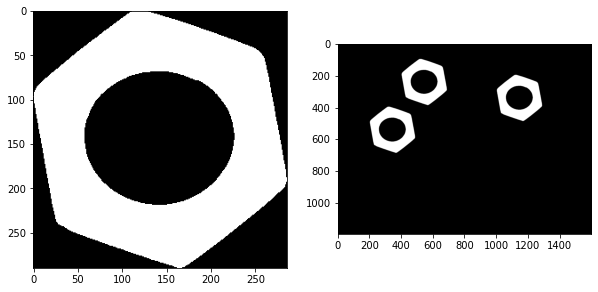

In [7]:
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

In [8]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

In [9]:
print(retval_t)
print(labels_t)
print(stats_t)
print(centroids_t)

2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
[[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]





*   How many connected compoonets are detected in each image? 2
*   What are the statistics? Interpret these statistics.


>Statistics to identify an object in a frame.
Column 1: cv.CC_STAT_LEFT: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
Column 2: cv.CC_STAT_TOP: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
Column 3: cv.CC_STAT_WIDTH: the horizontal size of the bounding box.
Column 4: cv.CC_STAT_HEIGHT: the vertical size of the bounding box.
Column 5: cv.CC_STAT_AREA: the total area (in pixels) of the connected component.



*   What are the centroids?
First element of Centroid_t represents the centroid of the background and the other one for the Nut.







In [10]:
print(retval_b)
print(labels_b)
print(stats_b)
print(centroids_b)

4
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


How many connected componets are detected in each image? 4

What are the centroids? First element of Centroid_b represents the centroid of the background and the other elements for each Nut.

In [11]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

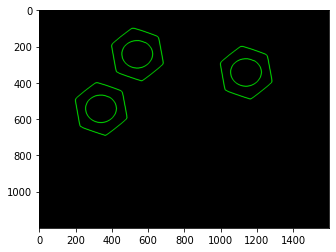

In [12]:
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)


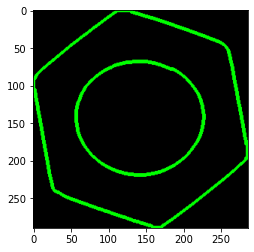

In [13]:
im_contours_tem = np.zeros((template_im.shape[0],template_im.shape[1],3), np.uint8)
conts_t = cv.drawContours(im_contours_tem, contours_t, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts_t)

In [14]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')   
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397151607
0.00010071698397928763
0.00010071698397484674


PART 2

In [15]:
ca=cv.contourArea(contours_b[1])

In [16]:
M=cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

In [17]:
count=1
object_prev_frame =np.array([cx,cy,ca,count])

In [18]:
delta_x=15

In [19]:
print(ca)
print(cx,cy)

20080.0
341 542


Part 3

In [20]:
def get_indexed_image(im):
    th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel = np.ones((3,3),dtype='uint8')
    closing_im = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_im)
    return retval, labels, stats, centroids

In [21]:
def is_new(a, b, delta, i): #finding the difference and comparing with delta    
    abs_diff = np.absolute(a - b)
    abs_diff[:,i] = (abs_diff[:,i] > delta[i]) 
    return abs_diff[:,i].all() 
    #return None

In [22]:
# check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert is_new(a, b, delta, i) == False, " Check the function "

In [23]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    abs_diff = np.absolute(a - b)
    abs_diff[:,i] = (abs_diff[:,i] <= delta[i])
    #print(abs_diff,i)
    index = np.where(abs_diff[:,i]) #returns the index    
    return index[0]    

In [24]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

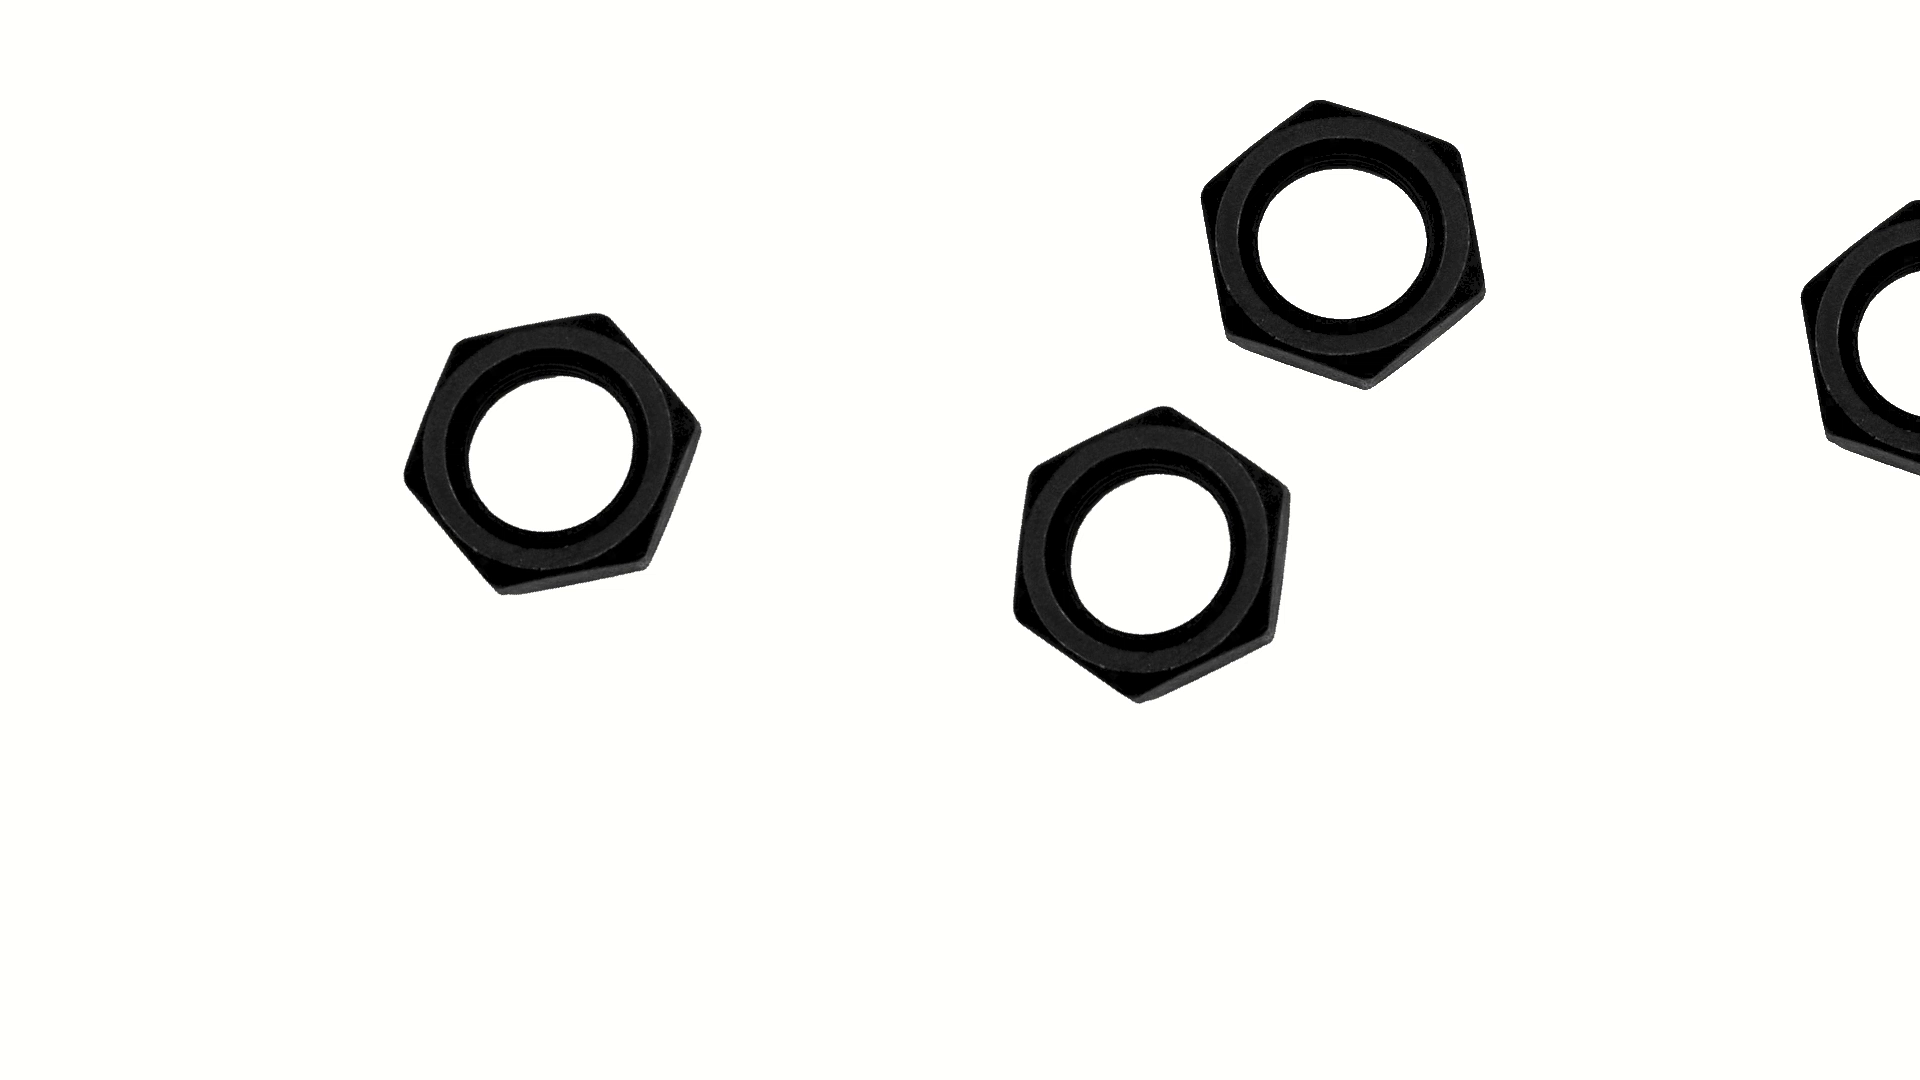

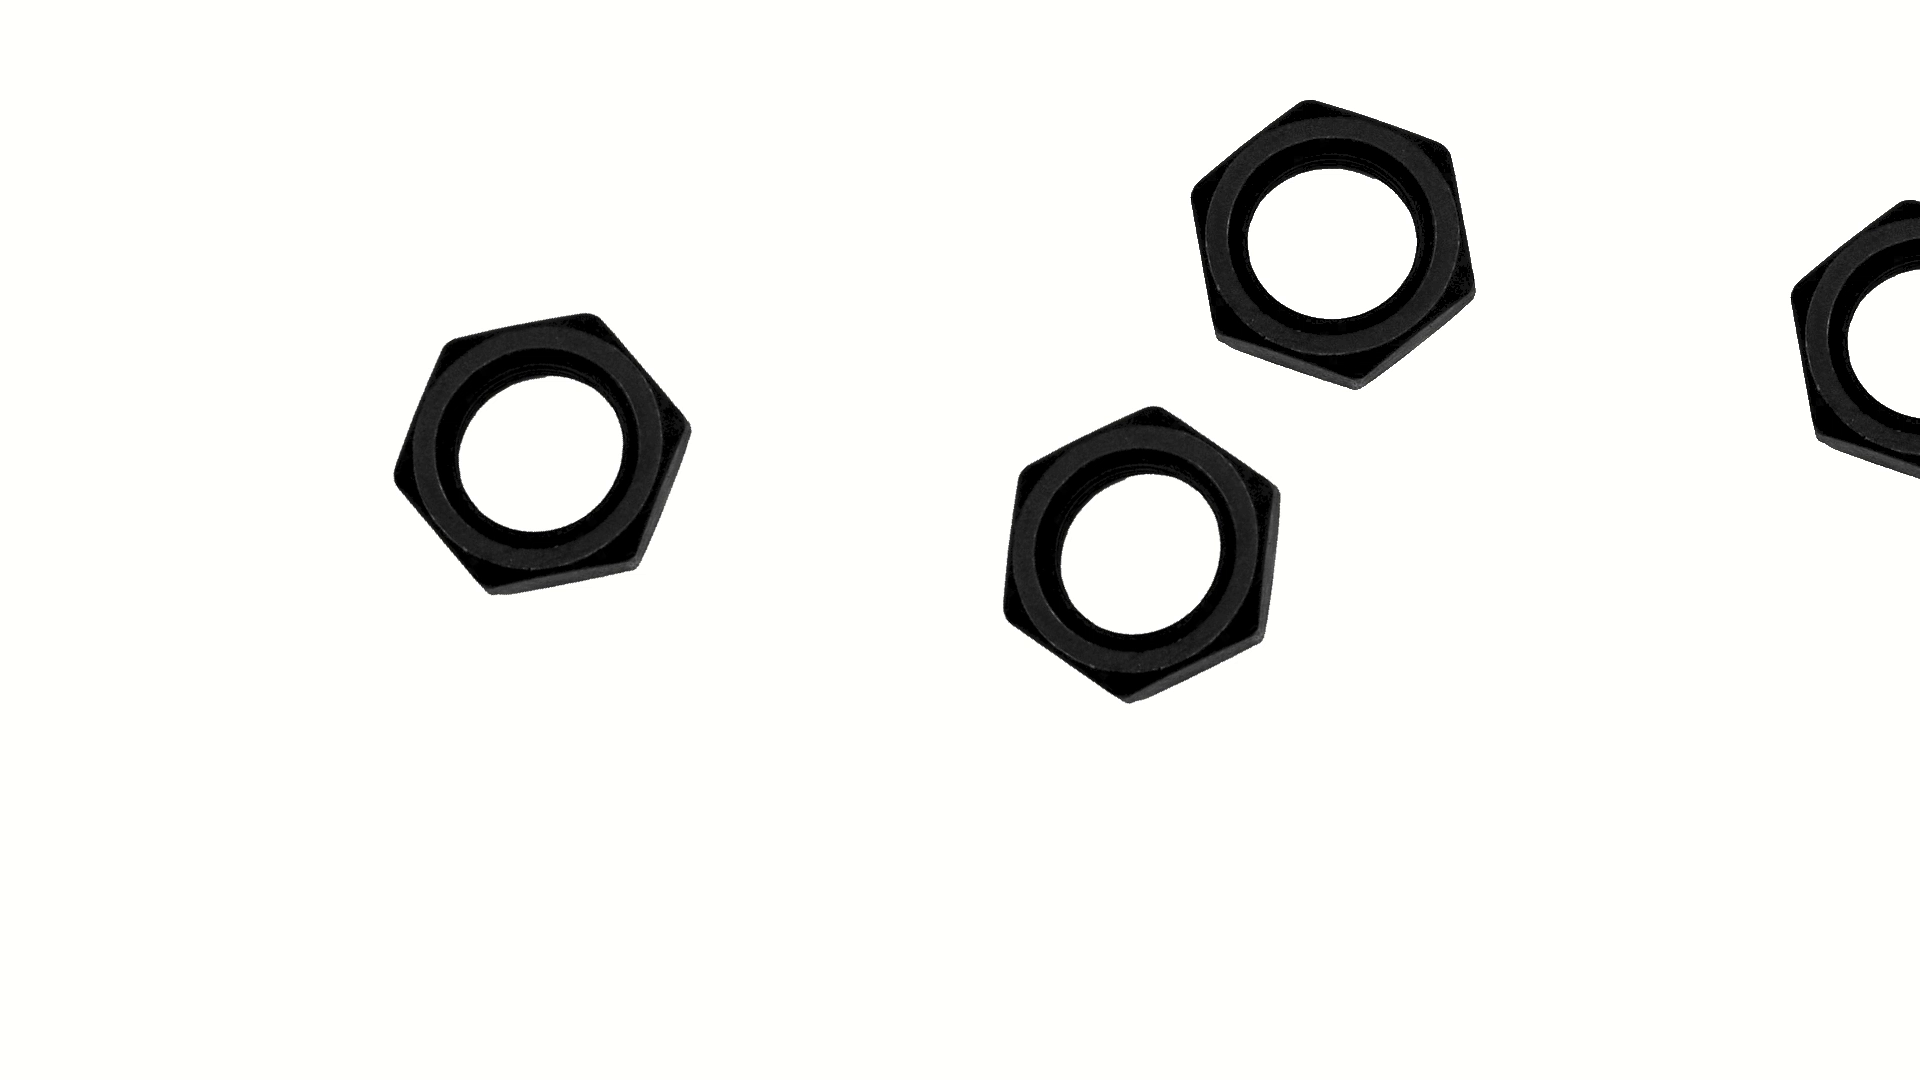

Can't receive frame (stream end?). Exiting ...


In [25]:
cap = cv.VideoCapture('conveyor_two_frame.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    cv2_imshow(frame)
    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows() 

**Implement a code to detect hexagonal nuts in a moving convey belt.**

In [88]:
frames = []  
cap = cv.VideoCapture('conveyor_with_rotation.mp4') 
print("Video capturing is in progress...")
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # convert to grayscale
    frames.append(frame)
    
    if cv.waitKey(1) == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()
print("Video capturing completed.")

Video capturing is in progress...
Can't receive frame (stream end?). Exiting ...
Video capturing completed.


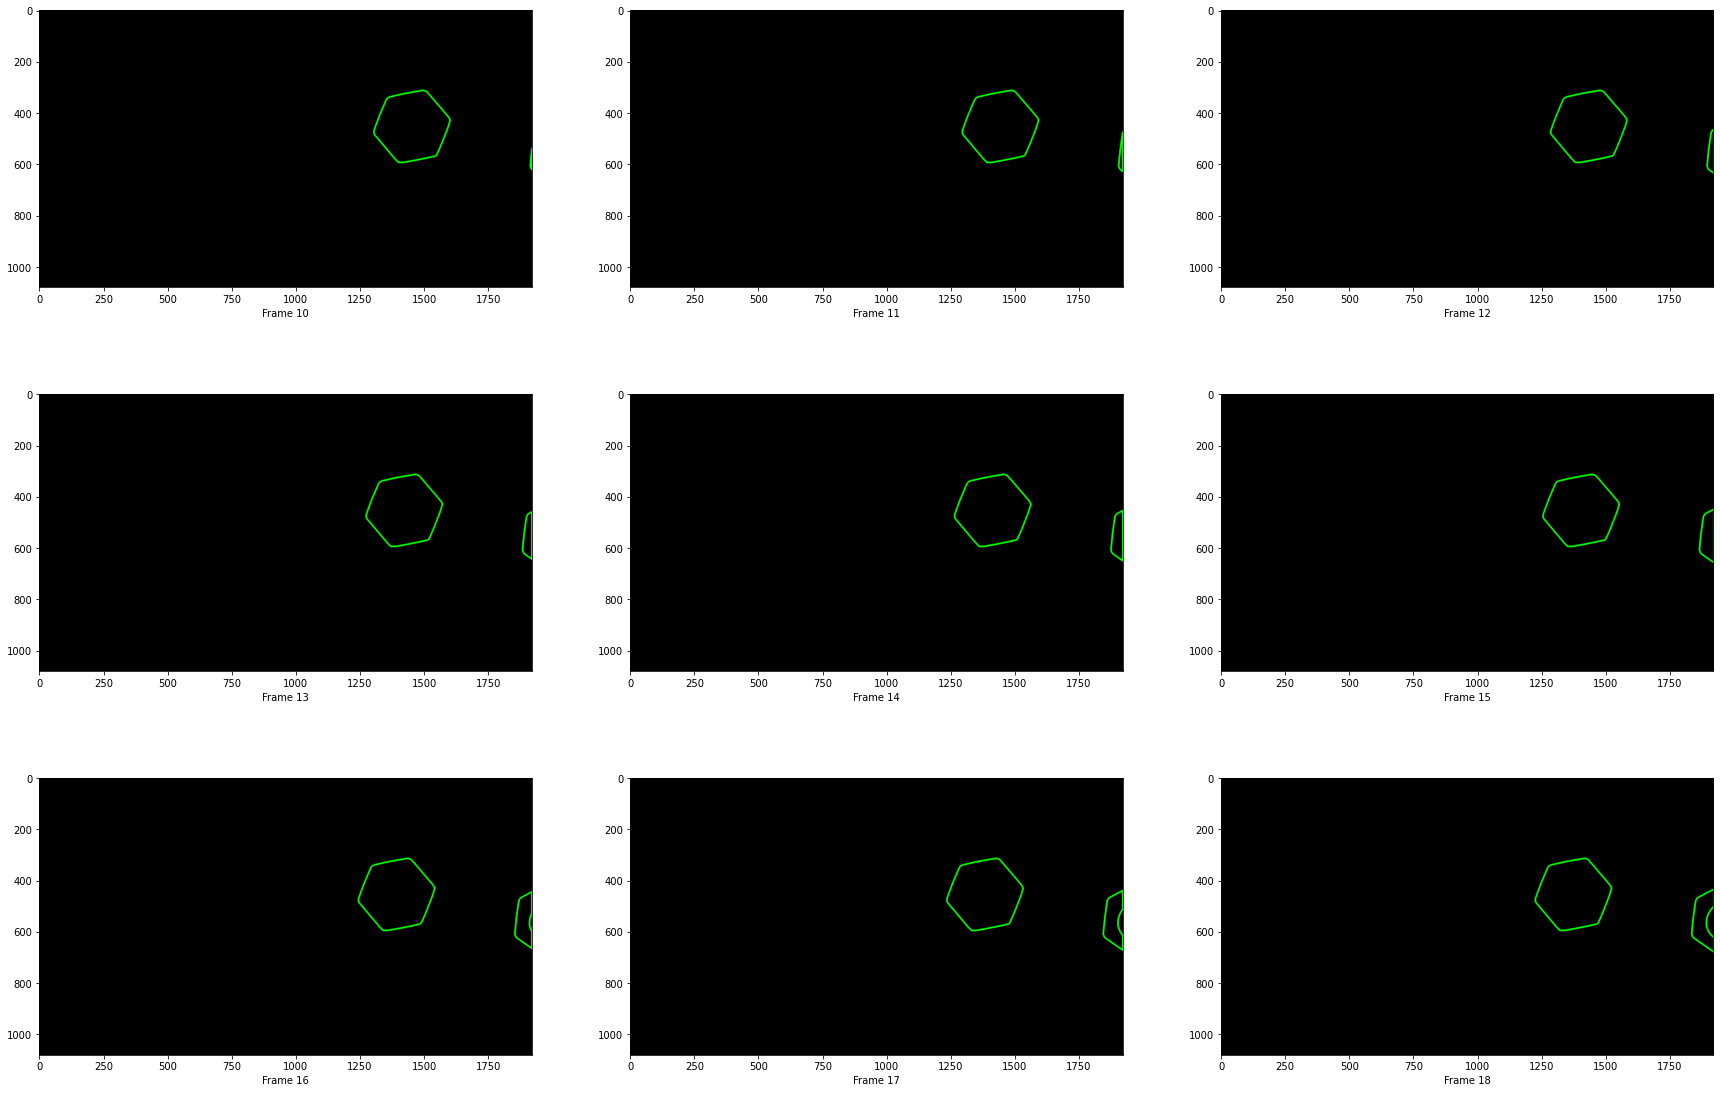

In [89]:
contours = [] # storing the plots
draw_contours = []
for frame in frames:
    retval, labels, stats, centroids = get_indexed_image(frame) 
    belt = ((labels >= 1)*255).astype('uint8') 
    contour,hierarchy  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours.append(contour)
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    contour = cv.drawContours(im_contours_belt, contour, -1, (0,255,0), 5).astype('uint8')
    draw_contours.append(contour)

plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(draw_contours[10+i])
    plt.xlabel("Frame " + str(10+i))
    #print(contours[10+i])
plt.show()

Object Detection and Tracking

In [90]:
video = []
print("........Extracting Details......")
for cont in contours:
    count = 0 
    editframe = []    
    for contour in cont:
        metric = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)       
        if metric <= 0.5: # matching threshold is 0.5
            count +=1
            M  = cv.moments(contour)
            ca = M['m00']
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            editframe.append(np.array([cx, cy, ca, count])) 
    #the count of the last contour in the frame wil be the total nuts in that frame
    video.append(editframe)
print("Extraction completed.")

........Extracting Details......
Extraction completed.


In [91]:
total_nuts = int(video[0][-1][-1]) 

delta_x = np.array([15])
i = np.array([0])
prev_frame = video[0]

for v in range(1, len(video)):
    current_frame = video[v]     
    for nuts in current_frame:
        if is_new(prev_frame, nuts, delta_x, i):#counting new nuts
            total_nuts +=1  
            nuts[-1] = total_nuts
        else: #changing the nut count
            index = prev_index(prev_frame, nuts, delta_x, i)                     
            nuts[-1]=prev_frame[int(index)][-1]    
    prev_frame = current_frame 
print("Total number of nuts: ",total_nuts)

Total number of nuts:  5


In [92]:
annotated =[] 
frame_no = 1
print("Frame annotation is in progress...")
for frame,draw_contours, contours in zip(video, draw_contours, contours):    
    img = draw_contours
    for nut in frame:        
        # Annotate the index of the nut
        img = cv.putText(img, str(int(nut[-1])),(int(nut[0]),int(nut[1])),cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 4)        
        # Annotate the Connected componets' details
        img = cv.putText(img, "Object {}: {:04} {:04} {:05}".format(int(nut[-1]), int(nut[0]), int(nut[1]), nut[2]),(50,850 + 70*(int(nut[-1])-2)), cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 4)        
          
    img = cv.putText(img, "Frame "+str(frame_no) , (1500,950) , cv.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3) # Annotate frame number   
    img = cv.drawContours(img, contours, -1, (0,255,0), 5).astype('uint8') # Draw the contours   
    img = cv.putText(img, "180428T" , (50,50) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3) #Annotate index number
    annotated.append(img)
    frame_no +=1
print("Annotation completed.")

Frame annotation is in progress...
Annotation completed.


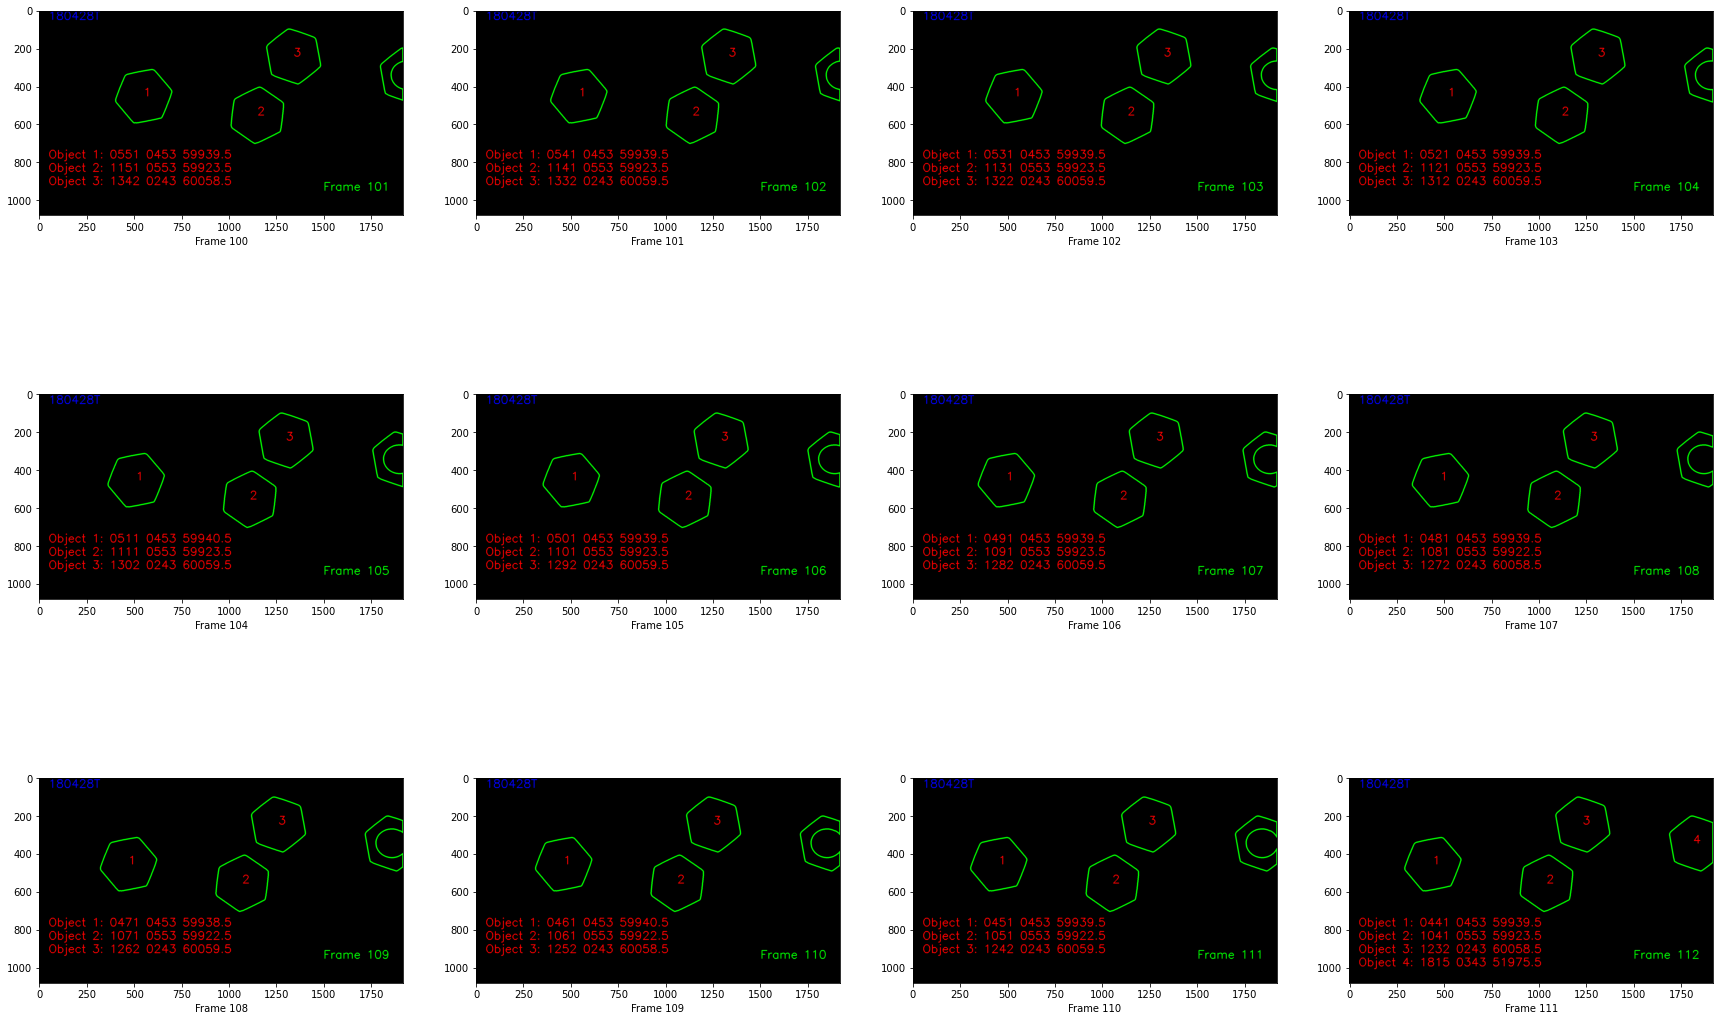

In [104]:
plt.figure(figsize=(30,20))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(annotated[100+i][:,:,::-1])
    plt.xlabel("Frame " + str(100+i))
    #cv2_imshow(annotated[250+i][:,:,::-1])
    #print(">>>>>>>>")
plt.show()

In [94]:
output = '180428T_en2550_a05.mp4' 
fourcc = cv.VideoWriter_fourcc(*'MP4V') 
duration = 9 # initial video's duration
fps = int(len(annotated)/duration) # frame per second
height, width,ch = annotated[0].shape
frame_size = (width, height)
isColor = True 

out = cv.VideoWriter(output, fourcc, fps, frame_size, isColor)
print("Video writer in progress...")
for frame in annotated:
    out.write(frame)
out.release()
print("Video writing completed.")

Video writer in progress...
Video writing completed.


'apt-get' is not recognized as an internal or external command,
operable program or batch file.
